<a href="https://colab.research.google.com/github/nepslor/teaching/blob/main/TimeSeriesForecasting/hierarchical_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hierarchical forecasting
In this exercise we will write a deterministic reconciliation algorithm. Given $n_d$ time series, $n_b$ bottom time series and $n_u$ aggregations, we want to reconcile the base forecasts produced independently.



This code can then be applied to probabilistic reconciliation through the following steps:

1. (Independently or jointly) sample from the predictive distribution ($[F_i(y_i)]_{i=1}^{n_d}$ or $F(y)$) of the base forecasters, obtaining $[y_{i, t+k}]_{i=1}^{n_d}$ set of sampled forecasts
2. reconcile the $k_{th}$ sample separately
3. repeat 1-2 for $K$ times, and empirically estimate the reconciled distribution 

In [1]:
%%capture
!pip install wget
import pandas as pd
import wget
import numpy as np
data = pd.read_pickle(wget.download("https://zenodo.org/record/4549296/files/reduced_dataset.pk?download=1"));

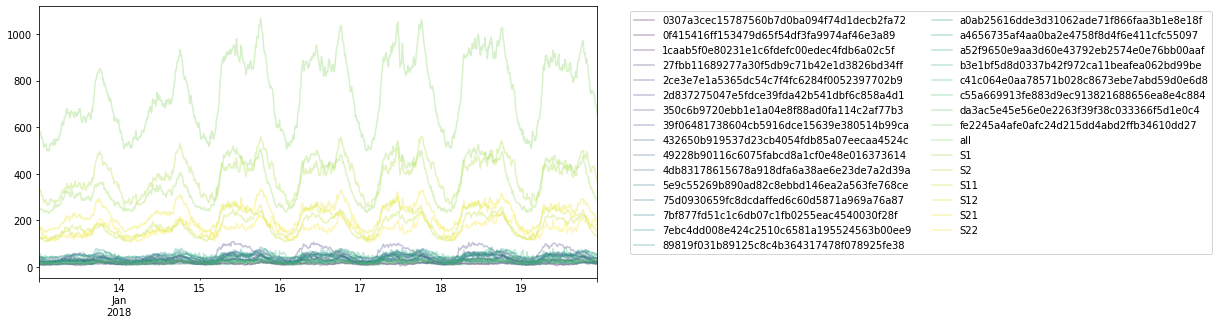

In [3]:
import matplotlib.pyplot as plt
power_series = [n for n in data.columns if n not in ["ghi_backwards", "temperature"]]
data[power_series].iloc[:1000,:].plot(alpha=0.3, cmap=plt.get_cmap('viridis'), figsize=(10, 5));
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2) 

❓Produce the set of base forecasters
For each one of the $n_d$ time series, produce independent point forecasts and collect them in the y_hat pd.DataFrame

In [ ]:

y_hat = None 

In [ ]:
from sklearn.covariance import ShrunkCovariance

def estimate_covariance(x, method):
    cov = ShrunkCovariance().fit(x)
    return cov.covariance_, cov.precision_
    

def get_projection_matrix(y, y_hat, ordered_cols, bottom_series, aggregated_series, s_matrix, method='dummy'):
  y = y[ordered_cols]
  y_hat = y_hat[ordered_cols]
  errs = y - y_hat

  n_b = len(bottom_series)
  n_u = len(aggregated_series)
  
  # get forecast errors for the bottom and upper time series
  err_b = errs.loc[:, bottom_series]
  err_u = errs.loc[:, aggregated_series]

  if method == 'dummy':
    precision = np.eye(n_b + n_u)
    p_matrix = np.linalg.inv(s_matrix.T @ precision @ s_matrix) @ (s_matrix.T @ precision)

  elif method == 'minT':
    cov, precision = estimate_covariance(errs.values)
    p_matrix = np.linalg.inv(s_matrix.T @ precision @ s_matrix) @ (s_matrix.T @ precision)
  
  return p_matrix


def reconcile(y_hat, s_matrix, p_matrix, ordered_cols):
  return s_matrix @ p_matrix @ y_hat[ordered_cols].T

